In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.rcParams.update({"figure.dpi": 200})
import stats_tests

In [12]:
# Run normality test on flowering time data
ft= pd.read_csv('processed.csv', index_col=0, header=None).transpose().astype({'5_FT10':np.float64})['5_FT10'].to_numpy()

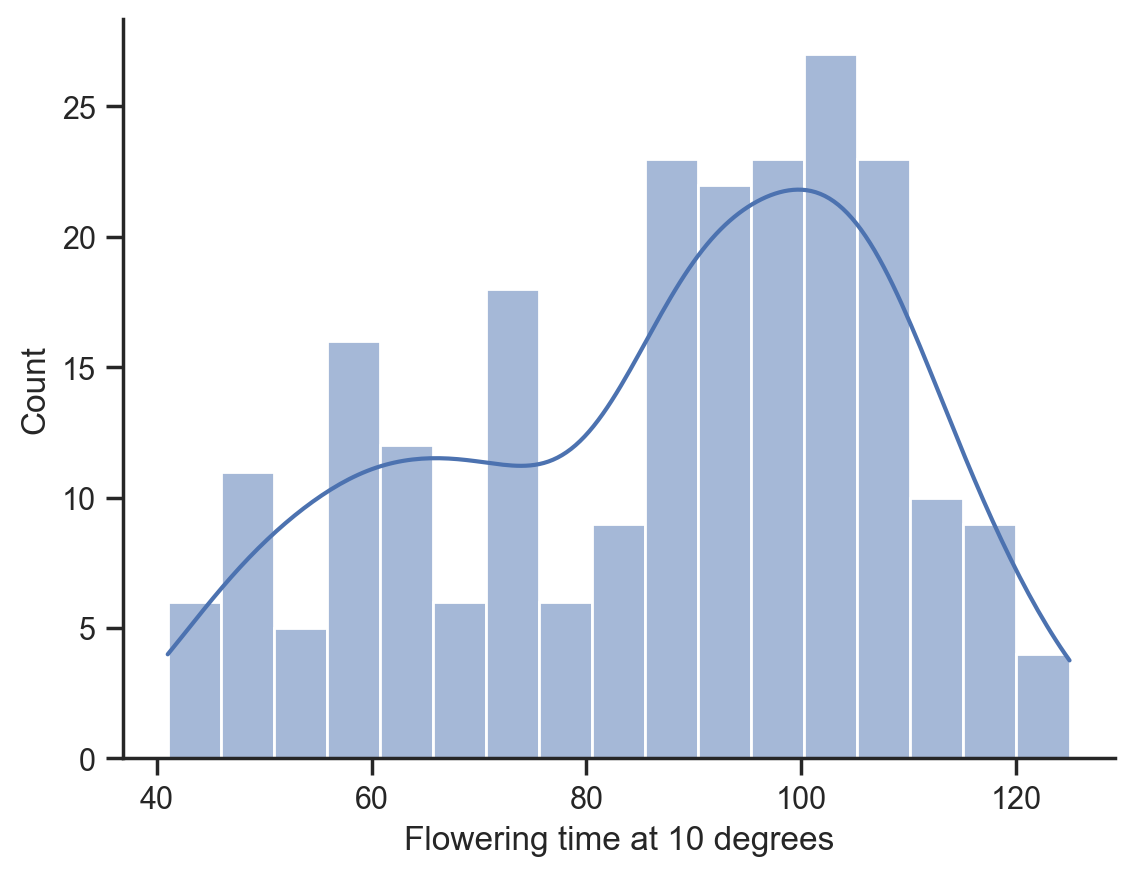

In [13]:
hist_plot = sns.histplot(x=ft, kde=True, binwidth=5)
hist_plot.set_xlabel('Flowering time at 10 degrees')
sns.set_theme(style='ticks')
sns.despine()
plt.show()

In [14]:
stats_tests.normality_test(ft)

KS test p-value: 0.011542904216882125
Shapiro test p-value: 5.966722958354086e-07


In [15]:
test_results = pd.read_csv('stat_test_results.csv')

In [ ]:
test_results['negative_log_p'] = -1 * np.log10(test_results['corrected_pval'])

# Adjust positions of SNPs for manhattan plot
test_results['chromosome'] = test_results['location'].map(lambda x: int(str.split(x, ':')[0]))
test_results['position'] = test_results['location'].map(lambda x: int(str.split(x, ':')[1]))
test_results['adjusted_position'] = test_results['position']

start_positions = np.cumsum([test_results.loc[test_results['chromosome'] == i, 'position'].max() for i in range(1,6)])
for i in range(1,5):
    test_results.loc[test_results['chromosome'] == i+1, 'adjusted_position'] = test_results.loc[test_results['chromosome'] == i+1, 'position'] + start_positions[i-1]

In [22]:
chromosomes = sorted(test_results['chromosome'].unique())
medians = [test_results.loc[test_results['chromosome'] == i, 'adjusted_position'].median() for i in chromosomes]

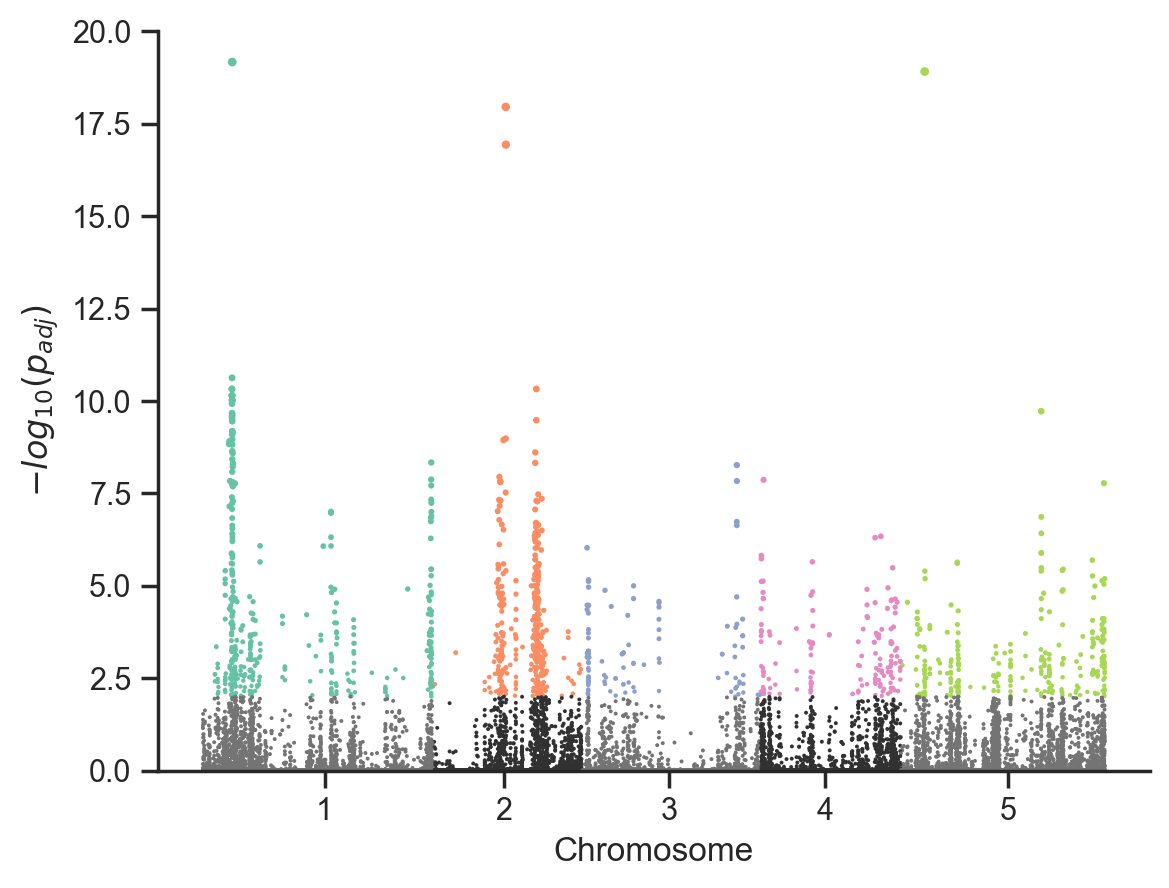

In [23]:
# Make Manhattan plot for Mann-Whitney test results
palette = sns.color_palette('Set2', 5)
gray_pallette = ["#747474", "#313131","#747474", "#313131", "#747474"]
manhattan = sns.scatterplot(data=test_results[test_results['negative_log_p'] > -np.log10(0.01)], x='adjusted_position', y='negative_log_p', 
                            hue='chromosome', marker='.', linewidth=0, size='negative_log_p', sizes=(10,40), palette=palette,legend=False)
sns.scatterplot(data=test_results[test_results['negative_log_p'] <= -np.log10(0.01)], x='adjusted_position', y='negative_log_p',
                 marker='.', linewidth=0, s=8, hue='chromosome', palette=gray_pallette, ax=manhattan, legend=False)
manhattan.set_xticks(medians, labels=[str(x) for x in chromosomes])
manhattan.set_ylim(0, 20)
manhattan.set_xlabel('Chromosome')
manhattan.set_ylabel(r'$-log_{10}(p_{adj})$')
sns.set_theme(style='ticks')
sns.despine()
plt.show()

In [25]:
# Original p-value correction still not conservative enough for permutation test; Using Bonferroni correction instead
m = test_results.shape[0]
test_results['perm_corrected_pval'] = test_results['perm_pval'] * m
test_results.loc[test_results['perm_corrected_pval'] > 1., 'perm_corrected_pval'] = 1

test_results['perm_negative_log_p'] = -1 * np.log10(test_results['perm_corrected_pval'])

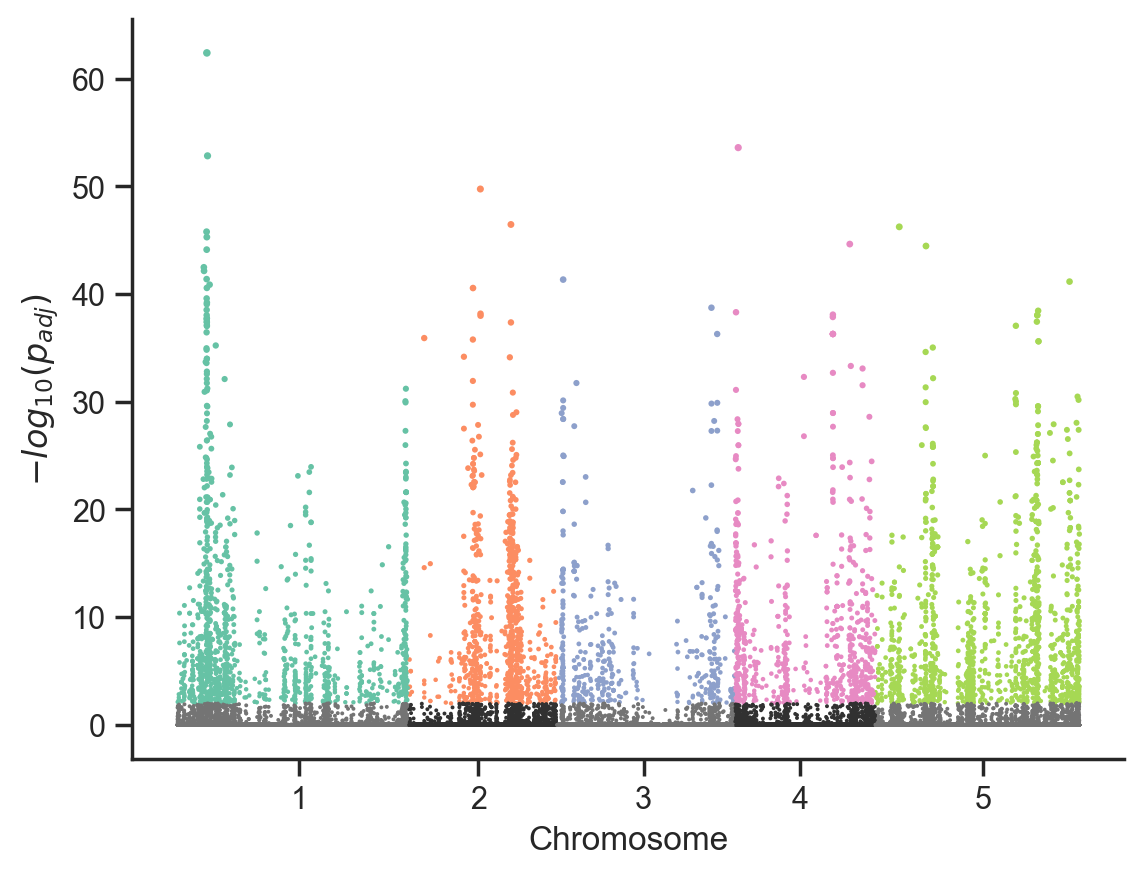

In [26]:
# Make Manhattan plot for permutation test results
perm_manhattan = sns.scatterplot(data=test_results[test_results['perm_negative_log_p'] > -np.log10(0.01)], x='adjusted_position', y='perm_negative_log_p', 
                            hue='chromosome', marker='.', linewidth=0, size='perm_negative_log_p', sizes=(10,30), palette=palette,legend=False)
sns.scatterplot(data=test_results[test_results['perm_negative_log_p'] <= -np.log10(0.01)], x='adjusted_position', y='perm_negative_log_p',
                 marker='.', linewidth=0, s=8, hue='chromosome', palette=gray_pallette, ax=perm_manhattan, legend=False)
perm_manhattan.set_xticks(medians, labels=[str(x) for x in chromosomes])
# perm_manhattan.set_ylim(0, 20)
perm_manhattan.set_xlabel('Chromosome')
perm_manhattan.set_ylabel(r'$-log_{10}(p_{adj})$')
sns.set_theme(style='ticks')
sns.despine()
plt.show()

In [27]:
# Example of edf/permutation test
example_data = pd.read_csv('processed.csv', index_col=0, header=None).transpose().astype({'5_FT10':np.float64})[['5_FT10', '1:13684483']]

In [28]:
[x,y] = [example_data.loc[example_data['1:13684483'] == g, '5_FT10'].to_numpy() for g in example_data.iloc[:,1].unique()]

In [29]:
result = stats_tests.permutation_test(x, y, {}, stats_tests.mean_diff, return_obs=True)
obs = result['observations']
edf = result['edf']

In [30]:
result

{'test_stat': np.float64(16.448311546840955),
 'pvalue': 1.8574566935378893e-10,
 'observations': array([1.90836964, 0.18159041, 3.56822803, ..., 1.06695715, 3.31339869,
        0.95619099], shape=(10000,)),
 'edf': <stats_tests.empirical_distribution at 0x106df52b0>}

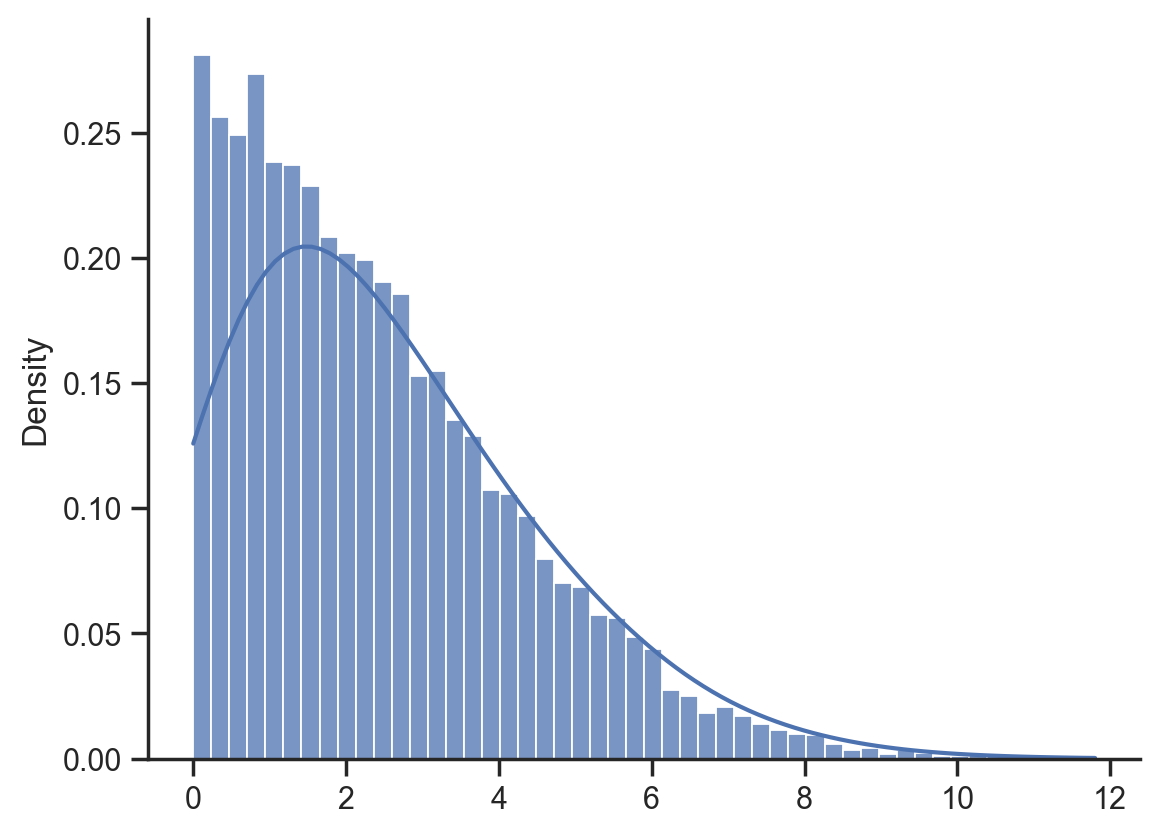

In [32]:
plot_x = np.linspace(min(obs), max(obs), 100)
plot_y = edf.pdf(plot_x)
sns.histplot(x=obs, stat='density')
sns.lineplot(x=plot_x, y=plot_y)
sns.despine()
plt.show()

In [ ]:
# Annotating manhattan plot using results from random forest feature importance analysis